In [1]:
import rasterio
import numpy as np
import joblib
import pandas as pd

In [4]:
def load_data(file_paths):
    # Load the data
    with rasterio.open(file_paths) as f:
        data = f.read(1).astype(np.float32)
        nodata = f.nodata
    # Mask the nodata values
    data_masked = np.ma.masked_equal(data, nodata)
    return data_masked
    
brightness = load_data('test/brightness.tif')
min_rgb = load_data('test/min_rgb.tif')
ndi_rb = load_data('test/ndi_rb.tif')
range_rgb = load_data('test/range_rgb.tif')
whiteness2 = load_data('test/whiteness2.tif')

In [5]:
brightness = brightness.filled(np.nan)
min_rgb = min_rgb.filled(np.nan)
ndi_rb = ndi_rb.filled(np.nan)
range_rgb = range_rgb.filled(np.nan)
whiteness2 = whiteness2.filled(np.nan)
# Stack lại thành mảng đặc trưng: (H, W, 5)
features = np.stack([brightness, min_rgb, ndi_rb, range_rgb, whiteness2], axis=-1)
H, W, num_features = features.shape

# Reshape để dự đoán: (H*W, 5)
X = features.reshape(-1, num_features)

# Tạo mặt nạ để loại pixel chứa NaN (do bị nodata)
valid_mask = ~np.isnan(X).any(axis=1)
X_valid = X[valid_mask]

In [6]:
model = joblib.load("best_random_forest_model.pkl")

# Dự đoán
feature_names = ['brightness', 'min_rgb', 'ndi_rb', 'range_rgb', 'whiteness2']
X_valid_df = pd.DataFrame(X_valid, columns=feature_names)
y_pred_valid = model.predict(X_valid_df)

In [9]:
import rasterio

# Khởi tạo mảng kết quả, gán -1 cho vùng không hợp lệ
y_pred_full = np.full((H * W), -1, dtype=np.int16)
y_pred_full[valid_mask] = y_pred_valid

# Reshape lại về bản đồ (H, W)
result_map = y_pred_full.reshape(H, W)

In [10]:
# Get profile and update with appropriate nodata value
with rasterio.open("sentinel4/brightness.tif") as src:
    profile = src.profile

# Update profile with int16 and valid nodata value
profile.update(
    dtype=rasterio.int16,
    count=1,
    nodata=-32768  # Using minimum int16 value as nodata
)

# Write result with proper nodata value
with rasterio.open("predict.tif", "w", **profile) as dst:
    # Replace -1 with -32768 for nodata regions
    result_map_final = np.where(result_map == -1, -32768, result_map)
    dst.write(result_map_final, 1)

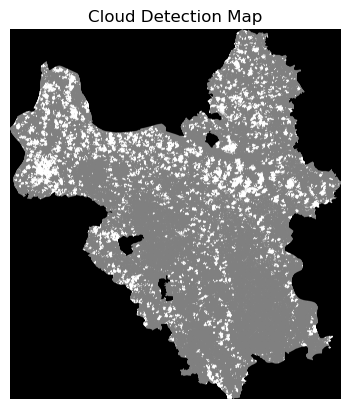

In [11]:
import matplotlib.pyplot as plt

plt.imshow(result_map, cmap="gray")
plt.title("Cloud Detection Map")
plt.axis("off")
plt.show()